In [1]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib

In [2]:
import random
import numpy as np
import brian2 as b2
from matplotlib import pyplot as plt
%matplotlib inline

#Patterns generation

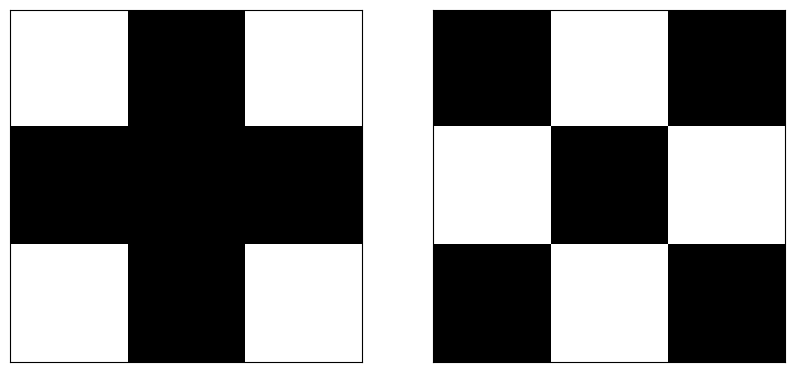

In [3]:
def draw_patterns(patterns):
  fig, ax = plt.subplots(nrows = 1, ncols = len(patterns), figsize=(10,5))
  for i,p in enumerate(patterns):
    ax[i].imshow(patterns[i], cmap='Greys')
    ax[i].tick_params(axis='both', labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                             bottom=False, top=False, left=False, right=False)

plus = np.array([0, 1, 0,
                 1, 1, 1,
                 0, 1, 0]).reshape(3,3)
cross = np.array([1, 0, 1,
                  0, 1, 0,
                  1, 0, 1]).reshape(3,3)
patterns = [plus, cross]
draw_patterns(patterns)

Gaussian noise

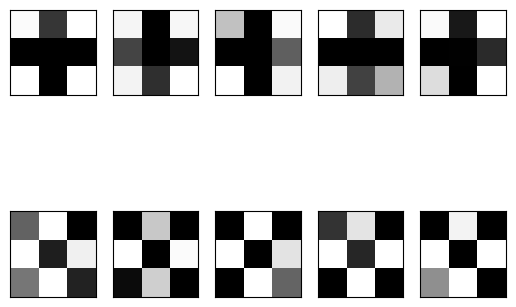

In [4]:
N_SAMPLE_CLASS = 20
rng = np.random.default_rng()
sample = []
sigma = 0.2
for _,p in enumerate(patterns):
  for i in range(N_SAMPLE_CLASS):
    sample += [np.clip(p + sigma*rng.standard_normal(p.shape),0,1)]
fig,axes = plt.subplots(len(patterns),5)
#plt.tick_params(axis='both', bottom=False, top=False, left=False, right=False)
for ip in range(len(patterns)):
  for ix in range(5):
    axes[ip][ix].imshow(sample[ix+ip*N_SAMPLE_CLASS], cmap="Greys")
    axes[ip][ix].tick_params(axis='both', labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                             bottom=False, top=False, left=False, right=False)

In [5]:
len(sample)

40

#Model

In [6]:
num_input = patterns[0].size # input layer
input_group = b2.PoissonGroup(num_input, rates=np.zeros(num_input)*b2.Hz)
n_e = 100 # e - excitatory
n_i = n_e # i - inhibitory

v_rest_e = -60.*b2.mV # v - membrane potential
v_reset_e = -65.*b2.mV
v_thresh_e = -52.*b2.mV

v_rest_i = -60.*b2.mV
v_reset_i = -45.*b2.mV
v_thresh_i = -40.*b2.mV

taupre = 20*b2.ms
taupost = taupre
gmax = .05 #.01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax 
dApre *= gmax 

In [7]:
# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp='''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''

In [8]:
app = {}
        

app['PG'] = b2.PoissonGroup(num_input, rates=np.zeros(num_input)*b2.Hz, name='PG')

# excitatory group
neuron_e = '''
    dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
    dge/dt = -ge / (5*ms) : 1
    dgi/dt = -gi / (10*ms) : 1
    '''
app['EG'] = b2.NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5*b2.ms, reset='v=v_reset_e', method='euler', name='EG')
app['EG'].v = v_rest_e - 20.*b2.mV

# ibhibitory group
neuron_i = '''
    dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
    dge/dt = -ge / (5*ms) : 1
    '''
app['IG'] = b2.NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*b2.ms, reset='v=v_reset_i', method='euler', name='IG')
app['IG'].v = v_rest_i - 20.*b2.mV

# poisson generators one-to-all excitatory neurons with plastic connections 
app['S1'] = b2.Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
app['S1'].connect()
app['S1'].w = 'rand()*gmax' # random weights initialisation
app['S1'].lr = 1 # enable stdp        

# excitatory neurons one-to-one inhibitory neurons
app['S2'] = b2.Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
app['S2'].connect(j='i')
app['S2'].delay = 'rand()*10*ms'
app['S2'].w = 3 # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

# inhibitory neurons one-to-all-except-one excitatory neurons
app['S3'] = b2.Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
app['S3'].connect(condition='i!=j')
app['S3'].delay = 'rand()*5*ms'
app['S3'].w = .03 # weights are selected in such a way as to maintain a balance between excitation and ibhibition

net = b2.Network(app.values())
net.run(0*b2.second)

WARNING    'i' is an internal variable of group 'S2', but also exists in the run namespace with the value 19. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'S3', but also exists in the run namespace with the value 19. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [9]:
def train(net, samples, epoch=1):        
    net['S1'].lr = 1 # stdp on

    for ep in range(epoch):
      for idx in range(len(samples)):
          # active mode
          net['PG'].rates = samples[idx].flatten()*b2.Hz
          net.run(0.35*b2.second)

          # passive mode
          net['PG'].rates = np.zeros(num_input)*b2.Hz
          net.run(0.15*b2.second)

##Обучение запустилось без ошибок

In [10]:
train(net, sample)

#Evaluation

In [11]:
def evaluate(net, X):       
    net['S1'].lr = 0  # stdp off

    features = []
    for idx in range(len(X)):
        # rate monitor to count spikes
        mon = b2.SpikeMonitor(net['EG'], name='RM')
        net.add(mon)
        
        # active mode
        net['PG'].rates = X[idx].ravel()*b2.Hz
        net.run(0.35*b2.second)
        
        # spikes per neuron foreach image
        features.append(np.array(mon.count, dtype=np.int8))
        
        # passive mode
        net['PG'].rates = np.zeros(num_input)*b2.Hz
        net.run(0.15*b2.second)
        
        net.remove(net['RM'])
        
    return features

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [13]:
features = evaluate(net, sample)

In [14]:
labels = np.concatenate([np.zeros(20),np.ones(20)])

## Metrics

In [15]:
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(features, labels)
print(clf.score(features, labels))

0.5
